100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training started...
Epoch [1/20], Train Loss: 1.6570, Train Acc: 40.83%, Val Loss: 1.4982, Val Acc: 47.70%
Epoch [2/20], Train Loss: 1.4351, Train Acc: 49.16%, Val Loss: 1.4193, Val Acc: 50.09%
Epoch [3/20], Train Loss: 1.3311, Train Acc: 53.27%, Val Loss: 1.3883, Val Acc: 50.93%
Epoch [4/20], Train Loss: 1.2430, Train Acc: 56.31%, Val Loss: 1.3623, Val Acc: 52.21%
Epoch [5/20], Train Loss: 1.1685, Train Acc: 58.78%, Val Loss: 1.3600, Val Acc: 52.74%
Epoch [6/20], Train Loss: 1.1014, Train Acc: 60.80%, Val Loss: 1.3617, Val Acc: 53.32%
Epoch [7/20], Train Loss: 1.0393, Train Acc: 63.11%, Val Loss: 1.3718, Val Acc: 53.34%
Epoch [8/20], Train Loss: 0.9801, Train Acc: 65.42%, Val Loss: 1.3841, Val Acc: 53.30%
Epoch [9/20], Train Loss: 0.9302, Train Acc: 67.12%, Val Loss: 1.4091, Val Acc: 54.20%
Epoch [10/20], Train Loss: 0.8701, Train Acc: 68.93%, Val Loss: 1.4254, Val Acc: 54.12%
Epoch [11/20], Train

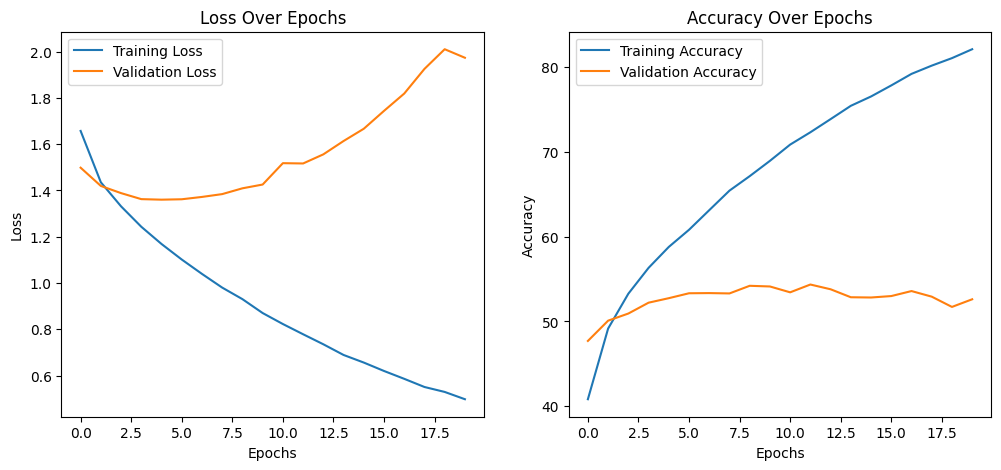


Classification Report:
              precision    recall  f1-score   support

    airplane       0.58      0.64      0.61      1000
  automobile       0.59      0.68      0.63      1000
        bird       0.46      0.39      0.42      1000
         cat       0.33      0.48      0.39      1000
        deer       0.46      0.41      0.44      1000
         dog       0.44      0.34      0.38      1000
        frog       0.59      0.59      0.59      1000
       horse       0.63      0.57      0.60      1000
        ship       0.66      0.62      0.64      1000
       truck       0.58      0.53      0.55      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000


Confusion Matrix:


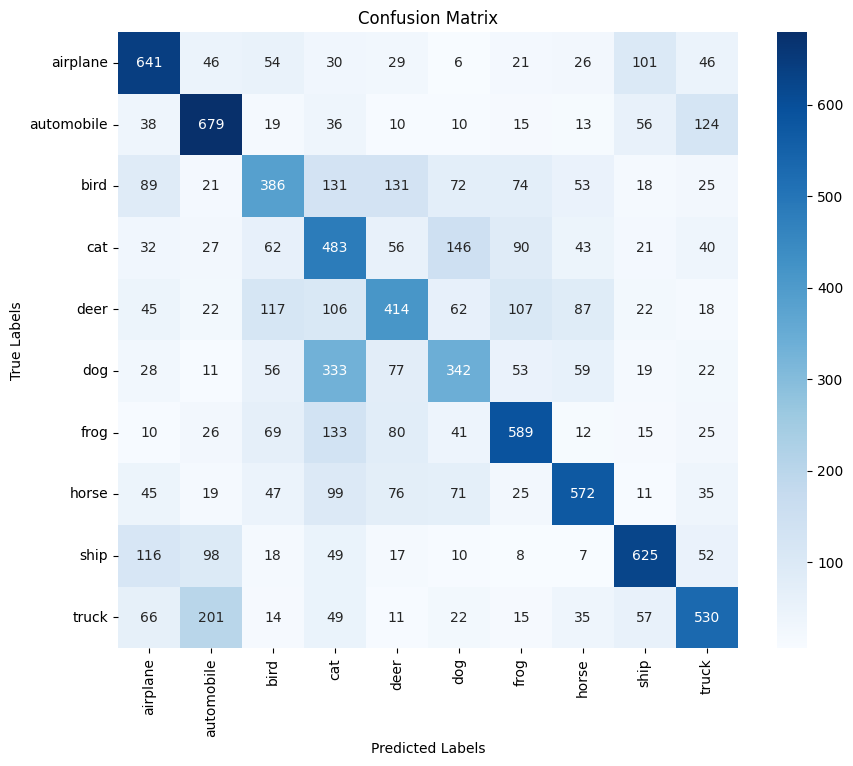

In [5]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Define data transformations
# Converting images to tensors and normalizing them to range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL images to tensors (0-1 range)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

# Load and prepare the CIFAR-10 dataset
# Training set with 50,000 images
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Test set with 10,000 images
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders for batch processing
# Batch size of 64 is a good balance between memory usage and training speed
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Problem 1a: Multi-Layer Perceptron Implementation
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Sequential container for the network layers
        self.model = nn.Sequential(
            nn.Flatten(),  # Flatten 32x32x3 input images to 3072 vector
            # First hidden layer: 3072 -> 256 neurons
            nn.Linear(32 * 32 * 3, 256),
            nn.ReLU(),  # ReLU activation for non-linearity
            # Second hidden layer: 256 -> 128 neurons
            nn.Linear(256, 128),
            nn.ReLU(),
            # Third hidden layer: 128 -> 64 neurons
            nn.Linear(128, 64),
            nn.ReLU(),
            # Output layer: 64 -> 10 classes (CIFAR-10 classes)
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

# Set up device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Appropriate for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Training hyperparameters
epochs = 20
# Lists to store metrics for plotting
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

print("Training started...")
start_time = time.time()

# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Move data to appropriate device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update weights

        # Calculate training metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate epoch metrics for training
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    # No gradient computation needed for validation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate epoch metrics for validation
    val_loss /= len(test_loader)
    val_acc = 100 * correct_val / total_val
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Print epoch results
    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Print total training time
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

# Save the trained model
torch.save(model.state_dict(), "mlp_cifar10.pth")

# Plotting training and validation metrics
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

# Final model evaluation
model.eval()
y_true, y_pred = [], []

# Collect predictions on test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate and print classification metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Generate and plot confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Training started...
Epoch [1/20], Train Loss: 1.6831, Train Acc: 40.18%, Val Loss: 1.5210, Val Acc: 46.51%
Epoch [2/20], Train Loss: 1.4532, Train Acc: 48.59%, Val Loss: 1.4223, Val Acc: 49.61%
Epoch [3/20], Train Loss: 1.3388, Train Acc: 52.63%, Val Loss: 1.3771, Val Acc: 51.85%
Epoch [4/20], Train Loss: 1.2413, Train Acc: 56.19%, Val Loss: 1.3545, Val Acc: 52.68%
Epoch [5/20], Train Loss: 1.1529, Train Acc: 59.15%, Val Loss: 1.3633, Val Acc: 52.87%
Epoch [6/20], Train Loss: 1.0789, Train Acc: 61.90%, Val Loss: 1.3490, Val Acc: 54.04%
Epoch [7/20], Train Loss: 1.0065, Train Acc: 64.21%, Val Loss: 1.3509, Val Acc: 55.03%
Epoch [8/20], Train Loss: 0.9328, Train Acc: 66.67%, Val Loss: 1.3614, Val Acc: 54.88%
Epoch [9/20], Train Loss: 0.8659, Train Acc: 69.05%, Val Loss: 1.4219, Val Acc: 54.57%
Epoch [10/20], Train Loss: 0.8049, Train Acc: 71.23%, Val Loss: 1.4657, Val Acc: 54.37%
Epoch [11/20], Train Loss: 0.7446, Train Acc: 73.11%, Val Loss: 1.5456, Val Acc: 54.68%
Epoch [12/20], Train 

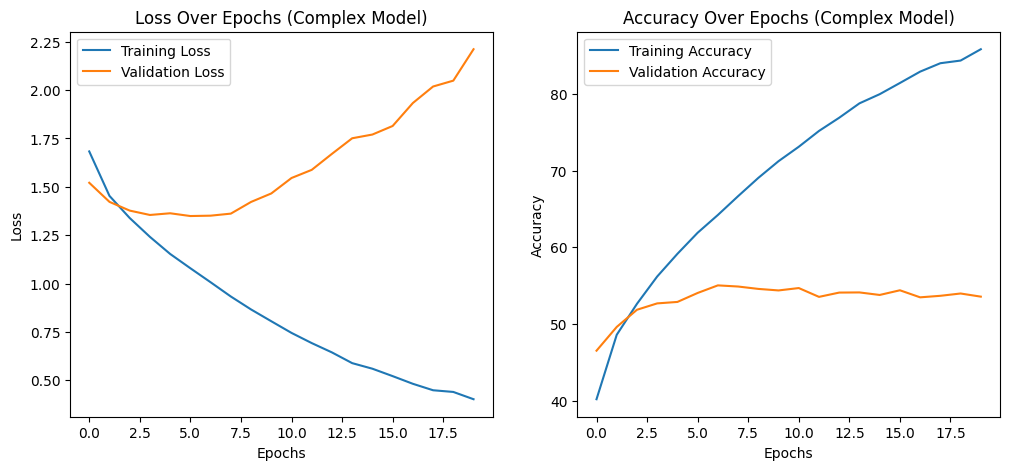


Classification Report (Problem 1b):
              precision    recall  f1-score   support

    airplane       0.60      0.64      0.62      1000
  automobile       0.65      0.68      0.66      1000
        bird       0.44      0.37      0.40      1000
         cat       0.33      0.36      0.35      1000
        deer       0.45      0.47      0.46      1000
         dog       0.44      0.41      0.42      1000
        frog       0.53      0.65      0.58      1000
       horse       0.67      0.54      0.60      1000
        ship       0.66      0.64      0.65      1000
       truck       0.60      0.60      0.60      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.53     10000
weighted avg       0.54      0.54      0.53     10000


Confusion Matrix (Problem 1b):


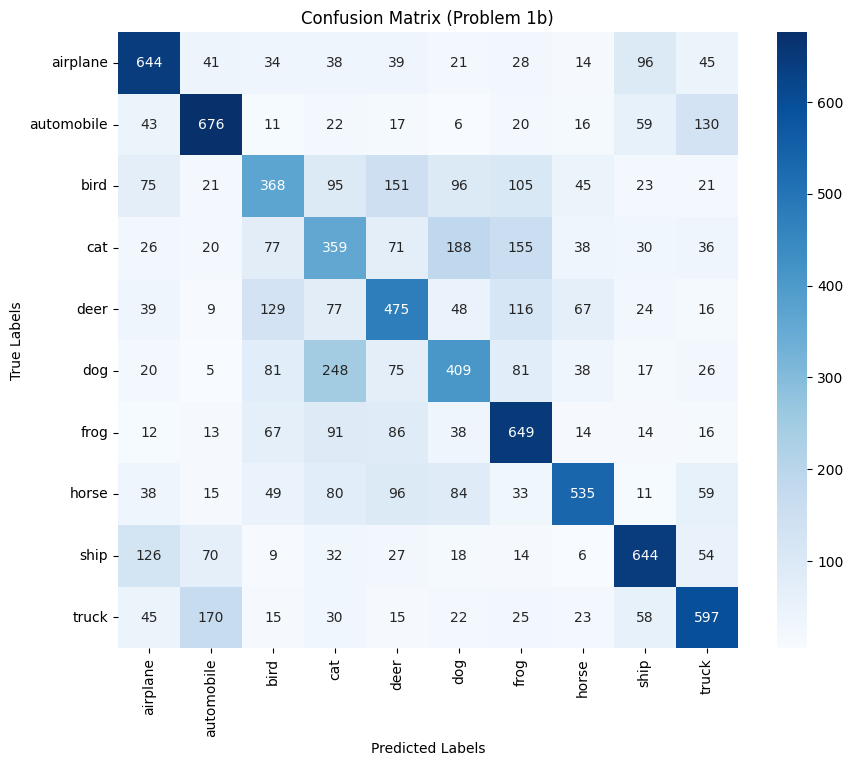

In [6]:
#Problem 1b
class ComplexMLP(nn.Module):
    def __init__(self):
        super(ComplexMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

complex_model = ComplexMLP().to(device)
optimizer = optim.Adam(complex_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 20
complex_train_loss_history, complex_val_loss_history = [], []
complex_train_acc_history, complex_val_acc_history = [], []

print("Training started...")
start_time = time.time()

for epoch in range(epochs):
    complex_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        outputs = complex_model(images)
        loss = criterion(outputs, labels)

        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    complex_train_loss_history.append(train_loss)
    complex_train_acc_history.append(train_acc)

    complex_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = complex_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(test_loader)
    val_acc = 100 * correct_val / total_val
    complex_val_loss_history.append(val_loss)
    complex_val_acc_history.append(val_acc)

    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

end_time = time.time()
print(f"Training for Problem 1b completed in {end_time - start_time:.2f} seconds.")

plt.figure(figsize=(12, 5))
#Loss
plt.subplot(1, 2, 1)
plt.plot(complex_train_loss_history, label='Training Loss')
plt.plot(complex_val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs (Complex Model)')

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(complex_train_acc_history, label='Training Accuracy')
plt.plot(complex_val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs (Complex Model)')

plt.show()

complex_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = complex_model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

#confusion matrix
print("\nClassification Report (Problem 1b):")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

print("\nConfusion Matrix (Problem 1b):")
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Problem 1b)')
plt.show()

Epoch [1/75], Training Loss: 1.4217, Validation Loss: 1.1208
Epoch [2/75], Training Loss: 0.8170, Validation Loss: 0.7019
Epoch [3/75], Training Loss: 0.5663, Validation Loss: 0.5948
Epoch [4/75], Training Loss: 0.5274, Validation Loss: 0.5930
Epoch [5/75], Training Loss: 0.5123, Validation Loss: 0.5990
Epoch [6/75], Training Loss: 0.5026, Validation Loss: 0.5945
Epoch [7/75], Training Loss: 0.4956, Validation Loss: 0.5970
Epoch [8/75], Training Loss: 0.4906, Validation Loss: 0.6031
Epoch [9/75], Training Loss: 0.4885, Validation Loss: 0.6058
Epoch [10/75], Training Loss: 0.4804, Validation Loss: 0.6004
Epoch [11/75], Training Loss: 0.4763, Validation Loss: 0.5976
Epoch [12/75], Training Loss: 0.4705, Validation Loss: 0.6002
Epoch [13/75], Training Loss: 0.4632, Validation Loss: 0.6081
Epoch [14/75], Training Loss: 0.4579, Validation Loss: 0.6103
Epoch [15/75], Training Loss: 0.4533, Validation Loss: 0.6107
Epoch [16/75], Training Loss: 0.4469, Validation Loss: 0.6107
Epoch [17/75], Tr

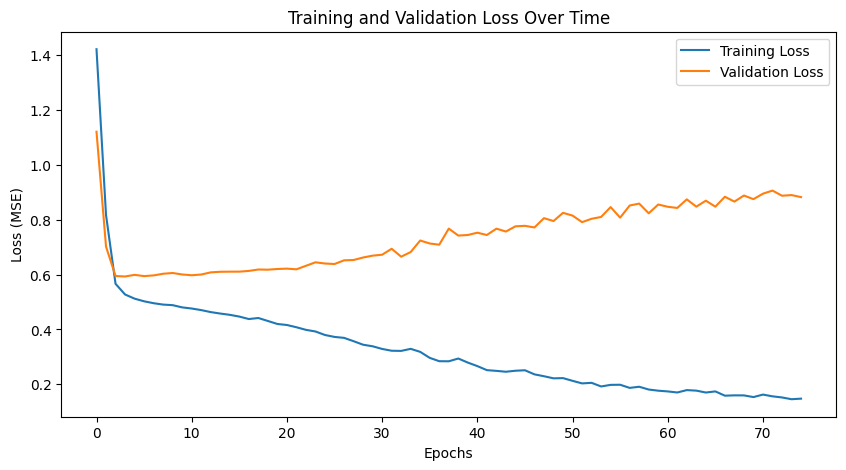

Final MSE on Validation Set: 0.8825
Final RMSE on Validation Set: 0.9394
Total Parameters in Model: 12033
Training Duration: 1.43 seconds


In [7]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load and prepare dataset
data_source = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv"
house_data = pd.read_csv(data_source)

# Convert categorical variables to numeric
for column in house_data.select_dtypes(include=['object']).columns:
    house_data[column] = house_data[column].astype('category').cat.codes

# Separate features and target
price_column = house_data.columns[-1]
input_features = house_data.drop([price_column], axis=1)
house_prices = house_data[price_column].values.reshape(-1, 1)

# Clean and scale the data
input_features = input_features.apply(pd.to_numeric, errors='coerce').fillna(0)
feature_scaler = StandardScaler()
input_features = feature_scaler.fit_transform(input_features)

# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(input_features, house_prices, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

# Define neural network architecture
class HousePriceNet(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer4(x)
        return x

# Initialize model and training components
input_dim = X_train.shape[1]
model = HousePriceNet(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 75
train_losses, valid_losses = [], []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_function(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)

    avg_train_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    valid_epoch_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            predictions = model(batch_X)
            loss = loss_function(predictions, batch_y)
            valid_epoch_loss += loss.item() * batch_X.size(0)

    avg_valid_loss = valid_epoch_loss / len(valid_loader.dataset)
    valid_losses.append(avg_valid_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")

total_time = time.time() - start_time

# Plot training results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

# Final evaluation
model.eval()
with torch.no_grad():
    X_valid_tensor, y_valid_tensor = X_valid_tensor.to(device), y_valid_tensor.to(device)
    final_predictions = model(X_valid_tensor)
    final_mse = loss_function(final_predictions, y_valid_tensor).item()
    final_rmse = np.sqrt(final_mse)

print(f"Final MSE on Validation Set: {final_mse:.4f}")
print(f"Final RMSE on Validation Set: {final_rmse:.4f}")
print(f"Total Parameters in Model: {sum(p.numel() for p in model.parameters())}")
print(f"Training Duration: {total_time:.2f} seconds")

Epoch [1/75], Training Loss: 1.1437, Validation Loss: 0.8269
Epoch [2/75], Training Loss: 0.6512, Validation Loss: 0.5879
Epoch [3/75], Training Loss: 0.5347, Validation Loss: 0.5875
Epoch [4/75], Training Loss: 0.5133, Validation Loss: 0.5787
Epoch [5/75], Training Loss: 0.4978, Validation Loss: 0.5818
Epoch [6/75], Training Loss: 0.4895, Validation Loss: 0.5807
Epoch [7/75], Training Loss: 0.4811, Validation Loss: 0.5796
Epoch [8/75], Training Loss: 0.4729, Validation Loss: 0.5894
Epoch [9/75], Training Loss: 0.4601, Validation Loss: 0.5843
Epoch [10/75], Training Loss: 0.4534, Validation Loss: 0.5900
Epoch [11/75], Training Loss: 0.4474, Validation Loss: 0.5803
Epoch [12/75], Training Loss: 0.4484, Validation Loss: 0.5811
Epoch [13/75], Training Loss: 0.4257, Validation Loss: 0.5901
Epoch [14/75], Training Loss: 0.4217, Validation Loss: 0.5849
Epoch [15/75], Training Loss: 0.4112, Validation Loss: 0.5870
Epoch [16/75], Training Loss: 0.3980, Validation Loss: 0.5929
Epoch [17/75], Tr

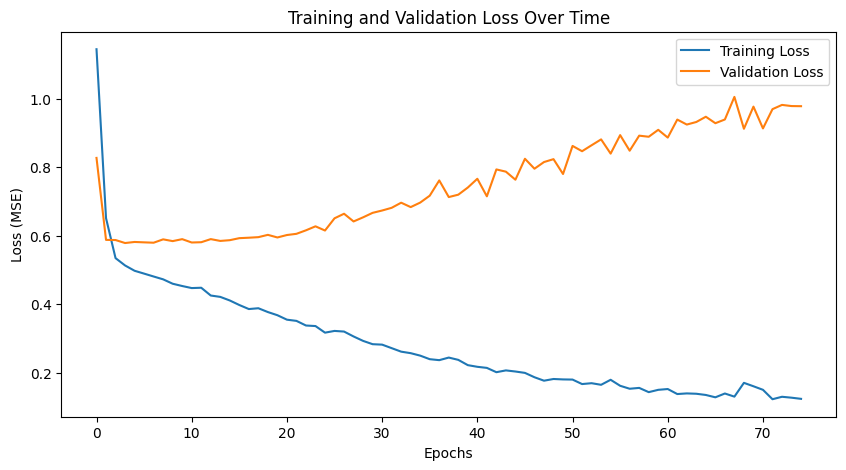

Final Validation MSE: 0.9777
Final Validation RMSE: 0.9888
Model Complexity (Total Parameters): 12033
Total Training Time: 1.44 seconds


In [8]:
#2b
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load housing dataset from GitHub repository
data_url = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv"
housing_dataset = pd.read_csv(data_url)

# Convert categorical variables to numeric codes
for col in housing_dataset.select_dtypes(include=['object']).columns:
    housing_dataset[col] = housing_dataset[col].astype('category').cat.codes

# Perform one-hot encoding on categorical variables
feature_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_cols = housing_dataset.select_dtypes(include=['category', 'object']).columns
encoded_features = feature_encoder.fit_transform(housing_dataset[categorical_cols])
encoded_features = pd.DataFrame(encoded_features, columns=feature_encoder.get_feature_names_out(categorical_cols))
housing_dataset = pd.concat([housing_dataset.drop(categorical_cols, axis=1), encoded_features], axis=1)

# Define target variable and separate features
target_column = "SalePrice"
if target_column not in housing_dataset.columns:
    target_column = housing_dataset.columns[-1]

input_data = housing_dataset.drop([target_column], axis=1)
price_targets = housing_dataset[target_column].values.reshape(-1, 1)

# Clean and scale the input features
input_data = input_data.apply(pd.to_numeric, errors='coerce').fillna(0)
data_scaler = StandardScaler()
input_data = data_scaler.fit_transform(input_data)

# Split data into training and validation sets
train_features, val_features, train_targets, val_targets = train_test_split(
    input_data, price_targets, test_size=0.2, random_state=42
)

# Convert numpy arrays to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_targets_tensor = torch.tensor(train_targets, dtype=torch.float32)
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
val_targets_tensor = torch.tensor(val_targets, dtype=torch.float32)

# Create DataLoader objects for batch processing
train_dataset = TensorDataset(train_features_tensor, train_targets_tensor)
val_dataset = TensorDataset(val_features_tensor, val_targets_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# Define neural network architecture for house price prediction
class HousePriceModel(nn.Module):
    def __init__(self, input_size):
        super(HousePriceModel, self).__init__()
        # Define network layers with descriptive names
        self.input_layer = nn.Linear(input_size, 128)
        self.hidden_layer1 = nn.Linear(128, 64)
        self.hidden_layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        # Apply ReLU activation after each layer except the output
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = self.output_layer(x)
        return x

# Initialize model and training components
input_dim = train_features.shape[1]
model = HousePriceModel(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
num_epochs = 75
training_losses = []
validation_losses = []
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    batch_loss = 0.0
    for batch_features, batch_targets in train_loader:
        # Move batch data to appropriate device
        batch_features = batch_features.to(device)
        batch_targets = batch_targets.to(device)
        
        # Forward pass and loss calculation
        optimizer.zero_grad()
        predictions = model(batch_features)
        loss = loss_function(predictions, batch_targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        batch_loss += loss.item() * batch_features.size(0)

    # Calculate average training loss
    avg_train_loss = batch_loss / len(train_loader.dataset)
    training_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_batch_loss = 0.0
    with torch.no_grad():
        for batch_features, batch_targets in val_loader:
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)
            predictions = model(batch_features)
            loss = loss_function(predictions, batch_targets)
            val_batch_loss += loss.item() * batch_features.size(0)

    # Calculate average validation loss
    avg_val_loss = val_batch_loss / len(val_loader.dataset)
    validation_losses.append(avg_val_loss)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Calculate total training time
total_time = time.time() - start_time

# Visualize training progress
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

# Final model evaluation
model.eval()
with torch.no_grad():
    val_features_tensor = val_features_tensor.to(device)
    val_targets_tensor = val_targets_tensor.to(device)
    final_predictions = model(val_features_tensor)
    final_mse = loss_function(final_predictions, val_targets_tensor).item()
    final_rmse = np.sqrt(final_mse)

# Print final metrics
print(f"Final Validation MSE: {final_mse:.4f}")
print(f"Final Validation RMSE: {final_rmse:.4f}")
print(f"Model Complexity (Total Parameters): {sum(p.numel() for p in model.parameters())}")
print(f"Total Training Time: {total_time:.2f} seconds")

Epoch [1/75], Training Loss: 1.1930, Validation Loss: 0.8170
Epoch [2/75], Training Loss: 0.5855, Validation Loss: 0.6001
Epoch [3/75], Training Loss: 0.5252, Validation Loss: 0.5919
Epoch [4/75], Training Loss: 0.5087, Validation Loss: 0.5972
Epoch [5/75], Training Loss: 0.4999, Validation Loss: 0.5971
Epoch [6/75], Training Loss: 0.4906, Validation Loss: 0.5949
Epoch [7/75], Training Loss: 0.4806, Validation Loss: 0.5930
Epoch [8/75], Training Loss: 0.4766, Validation Loss: 0.6022
Epoch [9/75], Training Loss: 0.4676, Validation Loss: 0.5984
Epoch [10/75], Training Loss: 0.4562, Validation Loss: 0.6335
Epoch [11/75], Training Loss: 0.4610, Validation Loss: 0.6140
Epoch [12/75], Training Loss: 0.4463, Validation Loss: 0.6072
Epoch [13/75], Training Loss: 0.4326, Validation Loss: 0.6163
Epoch [14/75], Training Loss: 0.4125, Validation Loss: 0.6333
Epoch [15/75], Training Loss: 0.4065, Validation Loss: 0.6306
Epoch [16/75], Training Loss: 0.3902, Validation Loss: 0.6447
Epoch [17/75], Tr

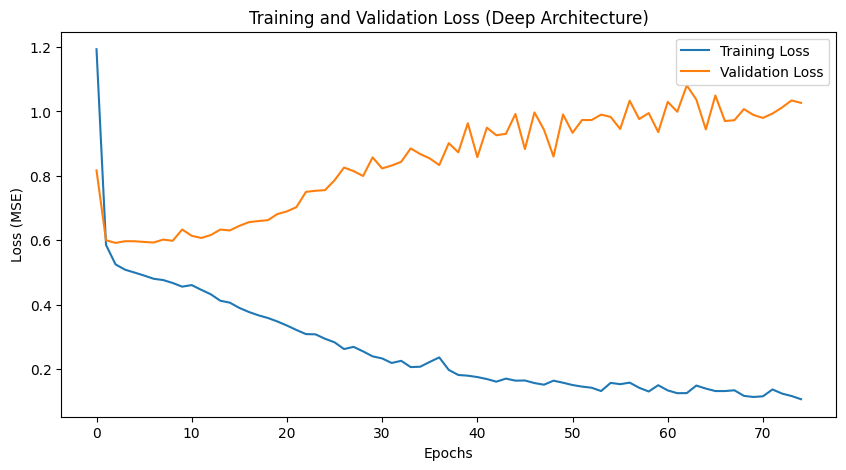

Final Validation MSE: 1.0264
Final Validation RMSE: 1.0131
Model Complexity (Total Parameters): 46593
Total Training Time: 1.55 seconds


In [9]:
#2c
# Import necessary libraries for the deep learning model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load the housing dataset
data_source = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv"
raw_data = pd.read_csv(data_source)

# Convert categorical variables to numeric codes
for column in raw_data.select_dtypes(include=['object']).columns:
    raw_data[column] = raw_data[column].astype('category').cat.codes

# Initialize and apply one-hot encoding
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_columns = raw_data.select_dtypes(include=['category', 'object']).columns
encoded_cats = cat_encoder.fit_transform(raw_data[cat_columns])
encoded_cats = pd.DataFrame(encoded_cats, columns=cat_encoder.get_feature_names_out(cat_columns))
processed_data = pd.concat([raw_data.drop(cat_columns, axis=1), encoded_cats], axis=1)

# Define and extract target variable
price_col = "SalePrice"
if price_col not in processed_data.columns:
    price_col = processed_data.columns[-1]

# Split features and target
house_features = processed_data.drop([price_col], axis=1)
house_prices = processed_data[price_col].values.reshape(-1, 1)

# Clean and scale the feature data
house_features = house_features.apply(pd.to_numeric, errors='coerce').fillna(0)
feature_scaler = StandardScaler()
scaled_features = feature_scaler.fit_transform(house_features)

# Split data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(scaled_features, house_prices, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
val_x_tensor = torch.tensor(val_x, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y, dtype=torch.float32)

# Create data loaders for batch processing
train_data = TensorDataset(train_x_tensor, train_y_tensor)
val_data = TensorDataset(val_x_tensor, val_y_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=False)

# Define deep neural network for house price prediction
class DeepHousingNet(nn.Module):
    def __init__(self, input_size):
        super(DeepHousingNet, self).__init__()
        # Deeper architecture with gradually decreasing layer sizes
        self.input_layer = nn.Linear(input_size, 256)
        self.hidden1 = nn.Linear(256, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.hidden3 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        # Forward pass with ReLU activation
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = self.output_layer(x)
        return x

# Initialize model and training components
input_dim = train_x.shape[1]
model = DeepHousingNet(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
num_epochs = 75
train_losses = []
val_losses = []
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        # Move batch to device and compute predictions
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # Forward and backward passes
        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = loss_fn(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)

    # Calculate average training loss
    avg_train_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            predictions = model(batch_x)
            loss = loss_fn(predictions, batch_y)
            val_loss += loss.item() * batch_x.size(0)

    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Calculate total training time
total_time = time.time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss (Deep Architecture)')
plt.legend()
plt.show()

# Final model evaluation
model.eval()
with torch.no_grad():
    val_x_tensor = val_x_tensor.to(device)
    val_y_tensor = val_y_tensor.to(device)
    final_preds = model(val_x_tensor)
    final_mse = loss_fn(final_preds, val_y_tensor).item()
    final_rmse = np.sqrt(final_mse)

# Print final metrics
print(f"Final Validation MSE: {final_mse:.4f}")
print(f"Final Validation RMSE: {final_rmse:.4f}")
print(f"Model Complexity (Total Parameters): {sum(p.numel() for p in model.parameters())}")
print(f"Total Training Time: {total_time:.2f} seconds")